In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import uncertainpy as un
from scipy.integrate import odeint
import chaospy as cp
import seaborn as sns

# USA data

In [130]:
# Upload data

df_prescription_opioids = pd.read_csv( 'od_data_prescription_opioids.csv', sep=';', decimal=',')
df_heroin = pd.read_csv('od_data_heroin.csv', sep=';', decimal=',')
df_fentanyl = pd.read_csv( 'od_data_fentanyl.csv', sep=';', decimal=',')

In [131]:
df_prescription_opioids.set_index('Year', inplace=True)
df_heroin.set_index('Year', inplace=True)
df_fentanyl.set_index('Year', inplace=True)

In [132]:
df_heroin.head()

,Average,Female,Male,White (Non-Hispanic),Black (Non-Hispanic),Asian or Pacific Islander (Non-Hispanic),Hispanic,American Indian or Alaska Native (Non-Hispanic)
Year,,,,,,,,
1999,0.7,0.2,1.2,0.7,0.8,0.0,1.1,0.0
2000,0.7,0.2,1.1,0.6,0.9,0.0,0.9,0.0
2001,0.6,0.2,1.0,0.6,0.8,0.0,0.9,0.0
2002,0.7,0.2,1.2,0.7,0.9,0.0,1.0,0.0
2003,0.7,0.2,1.2,0.7,0.8,0.0,1.0,0.0


In [133]:
# Consider only Average deaths (over 10'000) and merge the datasets

df_deaths = df_prescription_opioids[['Average']].merge(df_heroin[['Average']], left_index=True, right_index=True).merge(df_fentanyl[['Average']], left_index=True, right_index=True)
df_deaths.columns = ['prescription_opioids', 'heroin', 'fentanyl']
df_deaths.head()

,prescription_opioids,heroin,fentanyl
Year,,,
1999,1.2,0.7,0.3
2000,1.3,0.7,0.3
2001,1.7,0.6,0.3
2002,2.3,0.7,0.4
2003,2.6,0.7,0.5


In [404]:
import matplotlib.font_manager  as font_manager

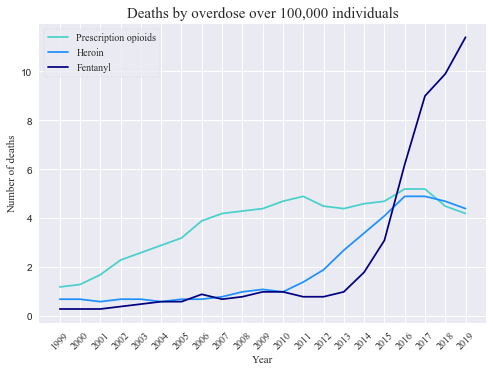

In [135]:
font = font_manager.FontProperties(family='Times New Roman')
#ax.legend(prop=font)
plt.style.use('seaborn')

#sns.color_palette("YlOrRd", as_cmap=True)
csfont = {'fontname':'Times New Roman'}
plt.plot(df_deaths.index, df_deaths['prescription_opioids'], color="mediumturquoise",label ="Prescription opioids")
plt.plot(df_deaths.index, df_deaths['heroin'], color="dodgerblue",label ="Heroin")
plt.plot(df_deaths.index, df_deaths['fentanyl'],color="navy"  ,label ="Fentanyl")

plt.title("Deaths by overdose over 100,000 individuals",fontsize=15, **csfont)
plt.ylabel("Number of deaths",fontsize=11, **csfont)
plt.xlabel("Year",**csfont)
plt.xticks(df_deaths.index, rotation=45,fontsize=10, **csfont)
plt.legend(frameon=True,prop=font )
plt.show();

#labels 
#plt.savefig("deaths.png")

In [136]:
%matplotlib inline

### Opioids death rate

#### Heroin

In [137]:
# How many people died in the US of heroin OD, in a sample of 100'000?

h_2019_death_sample = df_deaths.loc[2019, 'heroin']
h_2019_death_sample

4.4

In [138]:
# How many people died in the US of heroin OD, assuming tot population=326M?

h_2019_usa = h_2019_death_sample*(326*10**6)/(10**5)
h_2019_usa

14344.0

In [139]:
# How many people used heroin in 2019 in the us? 
'''
source: https://www.statista.com/statistics/611152/illicit-drug-users-number-past-year-in-the-us-by-drug/
other data: https://www.statista.com/topics/3088/drug-use-in-the-us/
'''

h_2019_users = 745 * 1000 
h_2019_users

745000

In [140]:
h_death_rate = h_2019_usa/h_2019_users
h_death_rate

0.019253691275167784

#### Fentanyl

We have data of fentanyl overdoses, but there is currently no estimate of fentanyl current users, so we cannot compute the death rate directly.

Another way is to compare the drug seiuzures and use them as a proxy.

In [141]:
def estimate_death_rate(seizure_h, seizure_f, year):

    user_h = df_deaths.loc[year, 'heroin']/h_death_rate
    
    # Using the proportion seizure_h : seizure_f = users_h : users_f
    proxy_users_f = (seizure_f * user_h)/seizure_h
    
    death_f = df_deaths.loc[year, 'fentanyl']
    
    f_death_rate = death_f/proxy_users_f
    return f_death_rate

In [142]:
'''
Using data from 2016
source: https://dataunodc.un.org/drugs/seizures

Most likely, the death rate comes up so high because because the seizures are probably under-reported as the substance is relatively new compared to heroin.
'''

estimate_death_rate(seizure_h=7173, seizure_f=365, year=2016)

0.4787596928174598

In [143]:
'''
Using data from 2018 and 2019
source: https://www.cbp.gov/newsroom/stats/drug-seizure-statistics

More reasonable estimate.

IMPORTANT: in 2021 heroin down and fentanyl up, but maybe outlier
'''

estimate_death_rate(seizure_h=5778, seizure_f=2283, year=2018)

0.10264149439990332

In [144]:
estimate_death_rate(seizure_h=6225, seizure_f=2801, year=2019)

0.11086448032701648

In [145]:
# Let us use a more conservative measure of 0.1

f_death_rate = 0.1

In [146]:
print(f"Fentanyl is more deadly than heroin by a factor of {f_death_rate/h_death_rate}")

Fentanyl is more deadly than heroin by a factor of 5.193809258226437


### Users from OD cases

In [147]:
# Death rates

death_rate_prescription_opioids = 0.007288 # natural death rate
death_rate_heroin = h_death_rate
death_rate_fentanyl = f_death_rate # to change

In [148]:
def inverse_death_rate(x, death_rate):
    return x/death_rate

In [149]:
# Compute number of users from deaths and death rate

df_current_users = df_deaths.copy()

df_current_users['prescription_opioids'] = df_current_users['prescription_opioids'].apply(lambda x: inverse_death_rate(x, death_rate_prescription_opioids))
df_current_users['heroin'] = df_current_users['heroin'].apply(lambda x: inverse_death_rate(x, death_rate_heroin))
df_current_users['fentanyl'] = df_current_users['fentanyl'].apply(lambda x: inverse_death_rate(x, death_rate_fentanyl))

In [150]:
df_current_users = df_current_users[['heroin', 'fentanyl']]

In [151]:
df_current_users

,heroin,fentanyl
Year,,
1999,36.356665,3.0
2000,36.356665,3.0
2001,31.162856,3.0
2002,36.356665,4.0
2003,36.356665,5.0
2004,31.162856,6.0
2005,36.356665,6.0
2006,36.356665,9.0
2007,41.550474,7.0


In [152]:
# All numbers in the data is relative to a population of 10'000 individuals
# Divide by N to obtain the fraction

N = 100000

df_current_users_fractions = df_current_users[['heroin', 'fentanyl']].copy()
df_current_users_fractions /= N

In [153]:
df_current_users_fractions.head()

,heroin,fentanyl
Year,,
1999,0.000364,0.00003
2000,0.000364,0.00003
2001,0.000312,0.00003
2002,0.000364,0.00004
2003,0.000364,0.00005


### Opioids supply

In [154]:
'''
The average seizure from Mexico around the year 2000 averages around 300 lbs/year

source: https://www.ojp.gov/pdffiles1/nij/218561.pdf
'''

seizure_mexico_2000 = 300

In [155]:
'''
Around the same time period, we know that heroin seizures from Mexico account for roughly 20% of the total

source: https://www.dea.gov/sites/default/files/2018-11/DIR-032-18%202018%20NDTA%20final%20low%20resolution.pdf
'''

ratio_mexico_2000 = 0.2

In [156]:
# Total heroin seizures 2000

total_heroin_2000 = seizure_mexico_2000/ratio_mexico_2000
total_heroin_2000

1500.0

In [157]:
# Fentanyl seizures are 0 at the beginning of the century

total_fentanyl_2000 = 0

total_opioids_2000 = total_heroin_2000 + total_fentanyl_2000
total_opioids_2000

1500.0

In [158]:
'''
In the second part of the 10s, heroin seizures averages around 6000 lbs per year.
Furthermore, fentanyl seizures averages around 2500 lbs per year.

We need to multiply fentanyl by 50 as this is the ratio of potency between heroin and fentanyl.

source: https://www.cbp.gov/newsroom/stats/drug-seizure-statistics
'''
# change numbers
total_opioids_2018 = 6000 + (2500*50)
total_opioids_2018

131000

In [159]:
# Therefore, the supply of opioids is 87 times higher after 2015 compared to early 2000s

ratio_supply_opioids = total_opioids_2018/total_opioids_2000
ratio_supply_opioids

87.33333333333333

In [160]:
# To extrapolate the multiplicative constant for the entire model, we average the 2 values

global_availability_ratio = (ratio_supply_opioids+1)/2
global_availability_ratio

44.166666666666664

### Odeint

In [161]:
# Total population

N = 100000

In [162]:

def return_standard_params(quarterly=False):

    params = dict()
    
    params['prescription_addiction'] = 0.001116 * 0.1 # prescription addiction -> heroin, include in sensitivity analysis [0.05-0.2]
    params['illegal_addiction_rate'] = 0.0036 
    params['f_laced_rate'] = 0.5 # upper_bound
    params['availability'] = global_availability_ratio
    params['lower_bound_f_laced_rate'] = False
    params['recovery_rate'] = 1.1 * 0.1 #[0.05-0.2]
    params['relapse_rate'] = 0.7 #[0.6-0.8]
    params['death_rate_heroin'] = death_rate_heroin
    params['death_rate_fentanyl'] = death_rate_fentanyl # +/- 0.01
    params['death_rate_natural'] = death_rate_prescription_opioids
    
    if quarterly:
        for k in params.keys():
            if k not in ['f_laced_rate', 'lower_bound_f_laced_rate']:
                params[k] /= 4
    
    return params

In [163]:
params = return_standard_params()

In [164]:
params

{'prescription_addiction': 0.0001116,
 'illegal_addiction_rate': 0.0036,
 'f_laced_rate': 0.5,
 'availability': 44.166666666666664,
 'lower_bound_f_laced_rate': False,
 'recovery_rate': 0.11000000000000001,
 'relapse_rate': 0.7,
 'death_rate_heroin': 0.019253691275167784,
 'death_rate_fentanyl': 0.1,
 'death_rate_natural': 0.007288}

In [165]:
def opioids_model(INPUT, t, params, net_conversion):
    
    S, H, F, R = INPUT[0], INPUT[1], INPUT[2], INPUT[3]
    N = S + H + F + R
    
    prescription_addiction = params['prescription_addiction']
    illegal_addiction_rate = params['illegal_addiction_rate']

    laced_exponent = -24.52*(F/H - 0.3)
    f_laced_rate = params['f_laced_rate'] / (1 + np.exp(laced_exponent))

    if params['lower_bound_f_laced_rate']:
        if not f_laced_rate > 0.01:
            f_laced_rate = 0.01

    availability = params['availability']

    recovery_rate = params['recovery_rate']
    relapse_rate = params['relapse_rate']

    death_rate_heroin = params['death_rate_heroin'] - params['death_rate_natural']
    death_rate_fentanyl = params['death_rate_fentanyl'] - params['death_rate_natural']
    
    S_d_t = -(prescription_addiction + illegal_addiction_rate*availability*(H+F)/N)*S + death_rate_heroin*H + death_rate_fentanyl*F
    H_d_t = (prescription_addiction + illegal_addiction_rate*availability*(H+F)/N)*S*(1-f_laced_rate) - f_laced_rate*H - net_conversion*H*F/N - recovery_rate*H + relapse_rate*H*R/N - death_rate_heroin*H
    F_d_t = (prescription_addiction + illegal_addiction_rate*availability*(H+F)/N)*S*f_laced_rate + f_laced_rate*H + net_conversion*H*F/N - recovery_rate*F + relapse_rate*F*R/N - death_rate_fentanyl*F
    R_d_t = recovery_rate*(H+F) - relapse_rate*R
    
    return S_d_t, H_d_t, F_d_t, R_d_t

In [79]:
# Compute y0, i.e. starting condition

def compute_y0(data, N, fraction=False):
    '''
    Return the starting settings as ratios with sum=1.
    We start with recovered = 0
    '''
    
    first_row = data.iloc[0, :]
    
    h = first_row['heroin']
    f = first_row['fentanyl']
    r = 0

    if fraction:
        N = 1

    s = N - h - f - r
    
    return s, h, f, r

In [80]:
def compute_starting_variables(data, N=N):

    ndays = data.shape[0]
    t = np.arange(1, ndays+1, 1) 

    y0 = compute_y0(data, N)

    return t, y0

In [81]:
def run_model(net_conversion, data, y0, t, model, error=False, df=False):
    
    RES = odeint(model, y0, t, args=(params, net_conversion))
    df_RES = pd.DataFrame(RES, columns=['s', 'h', 'f', 'r'])
    
    if error:
        RSS_heroin = ((df_RES['h'].to_numpy() - data['heroin'].to_numpy())**2).sum()
        RSS_fentanyl = ((df_RES['f'].to_numpy() - data['fentanyl'].to_numpy())**2).sum()
        RSS_total = RSS_heroin + RSS_fentanyl

        return RSS_heroin, RSS_fentanyl, RSS_total
    
    if df:
        return df_RES

In [82]:
# Because we have data for both heroin and fentanyl, to each net_conversion value we can actually associate 2 RSS:
# one for heroin, one for fentanyl.
# We should pick the global minimum (minimum of the sum), but it is better if the solution somewhat coincide for coherence.

def model_tuning(data, y0, t, net_conversion_values, model=opioids_model):

    RSS_heroin_list = []
    RSS_fentanyl_list = []
    RSS_list = []

    for net_conversion in net_conversion_values:
        
        RSS_heroin, RSS_fentanyl, RSS_total = run_model(net_conversion, data, y0, t, model, error=True)
        
        RSS_heroin_list.append(RSS_heroin)
        RSS_fentanyl_list.append(RSS_fentanyl)
        RSS_list.append(RSS_total)

    best_idx = RSS_list.index(min(RSS_list))
    best_net_conversion = net_conversion_values[best_idx]

    print(f"Fitting the model {len(net_conversion_values)} times")
    print(f"The best value to minimize heroin RSS is at index {RSS_heroin_list.index(min(RSS_heroin_list))}: {min(RSS_heroin_list)}")
    print(f"The best value to minimize fentanyl RSS is at index {RSS_fentanyl_list.index(min(RSS_fentanyl_list))}: {min(RSS_fentanyl_list)}")
    print(f"The best value to minimize both RSS (i.e. global solution) is at index {best_idx}: {RSS_list[best_idx]}")
    print(f"The best net conversion rate is {best_net_conversion}")

    return best_net_conversion

In [83]:
def best_model(best_net_conversion, data, y0, t, df=False, model=opioids_model):

  # Run the model with best net_conversion

    df_model = run_model(best_net_conversion, data, y0, t, model, df=True)

    if df:
        return df_model

    df_model[['h', 'f']].plot()
    data.plot()

### All data

In [84]:
# TODO: use to copy and paste below

data = df_current_users

In [85]:

'''
1. Create time and starting variables
'''

t, y0 = compute_starting_variables(data)

In [86]:
y0

(99960.64333519242, 36.356664807585055, 2.9999999999999996, 0)

In [87]:

'''
2. List of possibile values to try for the conversion rate.
   Compute RSS for each value and pick the best one.
'''

net_conversion_values = list(np.arange(0, 200, 0.5))

In [88]:
'''
3. Run model and find best net conversion value
'''

best_net_conversion = model_tuning(data, y0, t, net_conversion_values)

Fitting the model 400 times
The best value to minimize heroin RSS is at index 362: 172898.3555390082
The best value to minimize fentanyl RSS is at index 353: 7629.6059577114775
The best value to minimize both RSS (i.e. global solution) is at index 357: 182544.70453862642
The best net conversion rate is 178.5


In [89]:
best_model(best_net_conversion, data, y0, t, df=True)

,s,h,f,r
0,99960.643335,36.356665,3.000000,0.000000
1,99943.015654,49.226464,2.740191,3.666750
2,99923.484016,62.521980,2.546086,6.506763
3,99901.981739,76.252184,2.420987,8.975646
4,99878.440299,90.432931,2.361844,11.300637
5,99852.789135,105.078957,2.367383,13.595624
6,99824.955816,120.201563,2.440201,15.918247
7,99794.866373,135.807029,2.587980,18.298234
8,99762.445792,151.894584,2.825050,20.751438
9,99727.618758,168.453238,3.174884,23.286763


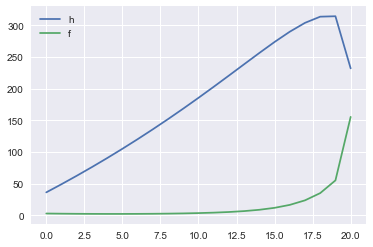

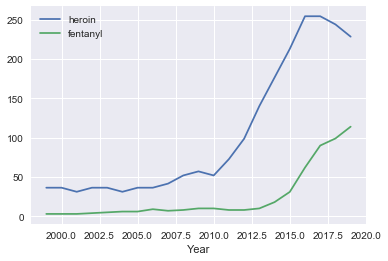

In [90]:
'''
4. Compute the best model using the best net conversion value.
   Plot the simulated values and the real values.
'''

best_model(best_net_conversion, data, y0, t)

## Parameters

In [91]:
best_net_conversion

178.5

In [92]:
# Normale --> calcolato
# Uniforme --> assunto
prescription_addiction = cp.Uniform(0.05*0.001116,0.2*0.001116)#moltiplicazione
illegal_addiction_rate = 0.0036
f_laced_rate = 0.5
recovery_rate =cp.Normal(0.1,0.04) #[0.09,0.11] 0.04
relapse_rate = cp.Normal(0.7,0.05) #[0.6,0.8] 0.05
net_conversion = best_net_conversion
availability = global_availability_ratio
death_rate_heroin = 0.015 
death_rate_fentanyl = cp.Normal(0.1,0.005) #[0.09,0.11]
death_rate_natural = death_rate_prescription_opioids

In [93]:
parameters = {'prescription_addiction':prescription_addiction,
 'illegal_addiction_rate':illegal_addiction_rate,
 'f_laced_rate':f_laced_rate,
 'recovery_rate':recovery_rate,
 'relapse_rate':relapse_rate,
 'death_rate_heroin':death_rate_heroin,
 'death_rate_fentanyl':death_rate_fentanyl,
    'net_conversion':net_conversion,
    'availability': availability,
    "death_rate_natural":death_rate_natural }

* The first order Sobol sensitivity index S measures the direct effect each parameter has on the variance of the model

(Si=V[E[Y|Qi]/V[Y])

* Here, E[Y|Qi] denotes the expected value of the output Y when parameter Qi is fixed. The first order Sobol sensitivity index tells us the expected reduction in the variance of the model when we fix parameter Qi. The sum of the first order Sobol sensitivity indices can not exceed one

https://uncertainpy.readthedocs.io/en/latest/theory/sa.html#:~:text=The%20first%20order%20Sobol%20sensitivity%20index%20tells%20us%20the%20expected,Glen%20and%20Isaacs%2C%202012).

In [278]:
def activation(variable,category):
    # Normale --> calcolato
# Uniforme --> assunto
    prescription_addiction = 0.1*0.001116#moltiplicazione
    illegal_addiction_rate = 0.0036
    f_laced_rate = 0.5
    recovery_rate = 0.1 #[0.09,0.11] 0.04
    relapse_rate = 0.7#[0.6,0.8] 0.05
    net_conversion = best_net_conversion
    availability = global_availability_ratio
    death_rate_heroin = 0.015 
    death_rate_fentanyl = 0.1 #[0.09,0.11]
    death_rate_natural = death_rate_prescription_opioids
    
    change  = {'prescription_addiction':cp.Uniform(0.05*0.001116,0.2*0.001116),
              'recovery_rate':cp.Normal(0.1,0.04),
                 'relapse_rate':cp.Normal(0.7,0.05),
              'death_rate_fentanyl':cp.Normal(0.1,0.005)}
    if variable == "prescription_addiction":
        prescription_addiction = change["prescription_addiction"]
    elif variable == "recovery_rate":
        recovery_rate = change["recovery_rate"]
    elif variable == "relapse_rate":
        relapse_rate = change["relapse_rate"]
    elif variable == "death_rate_fentanyl":
        death_rate_fentanyl = change["death_rate_fentanyl"]
    
    
    parameters = {'prescription_addiction':prescription_addiction,
     'illegal_addiction_rate':illegal_addiction_rate,
     'f_laced_rate':f_laced_rate,
     'recovery_rate':recovery_rate,
     'relapse_rate':relapse_rate,
     'death_rate_heroin':death_rate_heroin,
     'death_rate_fentanyl':death_rate_fentanyl,
        'net_conversion':net_conversion,
        'availability': availability,
        "death_rate_natural":death_rate_natural }
        
    if category == "S":
        model = un.Model(run = sensitivity_analysis_S,labels=["Time","S"])
    
        parameters = un.Parameters(parameters)
    
        UQ_S=un.UncertaintyQuantification(model=model,parameters=parameters)
    
        data_S = UQ_S.quantify()
    
        UQ_S.plot(folder=f'S {variable}')
        
    elif category == "H":
        model = un.Model(run = sensitivity_analysis_H,labels=["Time","H"])
    
        parameters = un.Parameters(parameters)
    
        UQ_S=un.UncertaintyQuantification(model=model,parameters=parameters)
    
        data_S = UQ_S.quantify()
    
        UQ_S.plot(folder=f'H {variable}')
        
    elif category == "F":
        model = un.Model(run = sensitivity_analysis_F,labels=["Time","F"])
    
        parameters = un.Parameters(parameters)
    
        UQ_S=un.UncertaintyQuantification(model=model,parameters=parameters)
    
        data_S = UQ_S.quantify()
    
        UQ_S.plot(folder=f'F {variable}')
        
    elif category == "R":
        model = un.Model(run = sensitivity_analysis_R,labels=["Time","R"])
    
        parameters = un.Parameters(parameters)
    
        UQ_S=un.UncertaintyQuantification(model=model,parameters=parameters)
    
        data_S = UQ_S.quantify()
    
        UQ_S.plot(folder=f'R {variable}')
       
    

In [279]:
activation("death_rate_fentanyl", "R")

On Windows machines everything in your script must be inside of an if __name__ == '__main__': block in order for multiprocess to work.


chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead
Calculating statistics from PCE:   0%|                                                           | 0/1 [00:00<?, ?it/s]

Only 1 uncertain parameter. Sensitivities are not calculated


Calculating statistics from PCE: 100%|███████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


Saving data as: data\sensitivity_analysis_R.h5
WARNING - All sobol_first_averages are missing. Unable to plot sobol_first_average_grid
WARNING - All sobol_first_averages are missing. Unable to plot sobol_first_average_grid


In [281]:
param = ["prescription_addiction","recovery_rate", "relapse_rate", "death_rate_fentanyl"]
categ = ["S","H","F","R"]

In [283]:
for par in param:
    activation("recovery_rate",par)

## S

In [2]:
def sensitivity_analysis_S(prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl,net_conversion, availability, death_rate_natural):
    import uncertainpy as un
    import chaospy as cp # To create distributions
    import numpy as np # For the time array
    from scipy.integrate import odeint
    ndays = 21
    
    S, H, F, R = (99960.64333519242, 36.356664807585055, 2.9999999999999996, 0)
    N = S+H+F+R
    t = range(1, ndays+1, 1)
    
    
    laced_exponent = -24.52*(F/H - 0.3)
    f_laced_rate = f_laced_rate/ (1 + np.exp(laced_exponent))
    
    #_______________
    death_rate_heroin = death_rate_heroin - death_rate_natural
    death_rate_fentanyl = death_rate_fentanyl - death_rate_natural
    
    def opioids_model(INPUT, t, prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl,net_conversion, availability, death_rate_natural):

        S, H, F, R = INPUT[0], INPUT[1], INPUT[2], INPUT[3]


        S_d_t = -(prescription_addiction + illegal_addiction_rate*availability*(H+F)/N)*S + death_rate_heroin*H + death_rate_fentanyl*F
        H_d_t = (prescription_addiction + illegal_addiction_rate*availability*(H+F)/N)*S*(1-f_laced_rate) - f_laced_rate*H - net_conversion*H*F/N - recovery_rate*H + relapse_rate*H*R/N - death_rate_heroin*H
        F_d_t = (prescription_addiction + illegal_addiction_rate*availability*(H+F)/N)*S*f_laced_rate + f_laced_rate*H + net_conversion*H*F/N - recovery_rate*F + relapse_rate*F*R/N - death_rate_fentanyl*F
        R_d_t = recovery_rate*(H+F) - relapse_rate*R

        return S_d_t, H_d_t, F_d_t, R_d_t
    cases = odeint(opioids_model, (S, H, F, R) , t, args=(prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl, net_conversion,availability, death_rate_natural) )
    return t,cases[:,0]
    
    
    

In [159]:
model = un.Model(run = sensitivity_analysis,labels=["Time","S"])

In [160]:
parameters = un.Parameters(parameters)

In [161]:
UQ_S=un.UncertaintyQuantification(model=model,parameters=parameters)

On Windows machines everything in your script must be inside of an if __name__ == '__main__': block in order for multiprocess to work.


In [162]:
data_S = UQ_S.quantify()

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead
Calculating statistics from PCE: 100%|███████████████████████████████████████████████████| 1/1 [00:44<00:00, 44.09s/it]


Saving data as: data\sensitivity_analysis.h5


In [163]:
UQ_S.plot(folder='S')
"""In summary, first‐order sensitivity indices as the main effect are used to measure the fractional contribution of
a single parameter to the output variance. 
Second‐order sensitivity indices are used to measure the fractional contribution of parameter interactions 
to the output variance."""

#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5006244/#:~:text=In%20summary%2C%20first%E2%80%90order%20sensitivity,interactions%20to%20the%20output%20variance.

'In summary, first‐order sensitivity indices as the main effect are used to measure the fractional contribution of\na single parameter to the output variance. \nSecond‐order sensitivity indices are used to measure the fractional contribution of parameter interactions \nto the output variance.'

UQ.plotting.sensitivity_1d(feature="sensitivity_analysis")

UQ.plotting.average_sensitivity_all()

UQ.plotting.plot_all_sensitivities()

UQ.plotting.plot_condensed()

## H

In [3]:
def sensitivity_analysis_H(prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl,net_conversion, availability, death_rate_natural):
    import uncertainpy as un
    import chaospy as cp # To create distributions
    import numpy as np # For the time array
    from scipy.integrate import odeint
    ndays = 21
    
    S, H, F, R = (99960.64333519242, 36.356664807585055, 2.9999999999999996, 0)
    N = S+H+F+R
    t = range(1, ndays+1, 1)
    
    
    laced_exponent = -24.52*(F/H - 0.3)
    f_laced_rate = f_laced_rate/ (1 + np.exp(laced_exponent))
    
    #_______________
    death_rate_heroin = death_rate_heroin - death_rate_natural
    death_rate_fentanyl = death_rate_fentanyl - death_rate_natural
    
    def opioids_model(INPUT, t, prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl,net_conversion, availability, death_rate_natural):

        S, H, F, R = INPUT[0], INPUT[1], INPUT[2], INPUT[3]


        S_d_t = -(prescription_addiction + illegal_addiction_rate*availability*(H+F)/N)*S + death_rate_heroin*H + death_rate_fentanyl*F
        H_d_t = (prescription_addiction + illegal_addiction_rate*availability*(H+F)/N)*S*(1-f_laced_rate) - f_laced_rate*H - net_conversion*H*F/N - recovery_rate*H + relapse_rate*H*R/N - death_rate_heroin*H
        F_d_t = (prescription_addiction + illegal_addiction_rate*availability*(H+F)/N)*S*f_laced_rate + f_laced_rate*H + net_conversion*H*F/N - recovery_rate*F + relapse_rate*F*R/N - death_rate_fentanyl*F
        R_d_t = recovery_rate*(H+F) - relapse_rate*R

        return S_d_t, H_d_t, F_d_t, R_d_t
    cases = odeint(opioids_model, (S, H, F, R) , t, args=(prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl, net_conversion,availability, death_rate_natural) )
    return t,cases[:,1]
    
    

In [165]:
model = un.Model(run = sensitivity_analysis,labels=["Time","H"])

In [166]:
parameters = un.Parameters(parameters)

In [167]:
UQ_H=un.UncertaintyQuantification(model=model,parameters=parameters)

On Windows machines everything in your script must be inside of an if __name__ == '__main__': block in order for multiprocess to work.


In [168]:
data_H = UQ_H.quantify()

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead
Calculating statistics from PCE: 100%|███████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.49s/it]


Saving data as: data\sensitivity_analysis.h5


In [169]:
UQ_H.plot(folder='H')
"""In summary, first‐order sensitivity indices as the main effect are used to measure the fractional contribution of
a single parameter to the output variance. 
Second‐order sensitivity indices are used to measure the fractional contribution of parameter interactions 
to the output variance."""

#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5006244/#:~:text=In%20summary%2C%20first%E2%80%90order%20sensitivity,interactions%20to%20the%20output%20variance.

'In summary, first‐order sensitivity indices as the main effect are used to measure the fractional contribution of\na single parameter to the output variance. \nSecond‐order sensitivity indices are used to measure the fractional contribution of parameter interactions \nto the output variance.'

UQ.plotting.sensitivity_1d(feature="sensitivity_analysis")

UQ.plotting.average_sensitivity_all()

UQ.plotting.plot_all_sensitivities()

UQ.plotting.plot_condensed()

## F

In [4]:
def sensitivity_analysis_F(prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl,net_conversion, availability, death_rate_natural):
    import uncertainpy as un
    import chaospy as cp # To create distributions
    import numpy as np # For the time array
    from scipy.integrate import odeint
    ndays = 21
    
    S, H, F, R = (99960.64333519242, 36.356664807585055, 2.9999999999999996, 0)
    N = S+H+F+R
    t = range(1, ndays+1, 1)
    
    
    laced_exponent = -24.52*(F/H - 0.3)
    f_laced_rate = f_laced_rate/ (1 + np.exp(laced_exponent))
    
    #_______________
    death_rate_heroin = death_rate_heroin - death_rate_natural
    death_rate_fentanyl = death_rate_fentanyl - death_rate_natural
    
    def opioids_model(INPUT, t, prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl,net_conversion, availability, death_rate_natural):

        S, H, F, R = INPUT[0], INPUT[1], INPUT[2], INPUT[3]


        S_d_t = -(prescription_addiction + illegal_addiction_rate*availability*(H+F)/N)*S + death_rate_heroin*H + death_rate_fentanyl*F
        H_d_t = (prescription_addiction + illegal_addiction_rate*availability*(H+F)/N)*S*(1-f_laced_rate) - f_laced_rate*H - net_conversion*H*F/N - recovery_rate*H + relapse_rate*H*R/N - death_rate_heroin*H
        F_d_t = (prescription_addiction + illegal_addiction_rate*availability*(H+F)/N)*S*f_laced_rate + f_laced_rate*H + net_conversion*H*F/N - recovery_rate*F + relapse_rate*F*R/N - death_rate_fentanyl*F
        R_d_t = recovery_rate*(H+F) - relapse_rate*R

        return S_d_t, H_d_t, F_d_t, R_d_t
    cases = odeint(opioids_model, (S, H, F, R) , t, args=(prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl, net_conversion,availability, death_rate_natural) )
    return t,cases[:,2]
    
    
    

In [171]:
model = un.Model(run = sensitivity_analysis,labels=["Time","F"])

In [172]:
parameters = un.Parameters(parameters)

In [173]:
UQ_F=un.UncertaintyQuantification(model=model,parameters=parameters)

On Windows machines everything in your script must be inside of an if __name__ == '__main__': block in order for multiprocess to work.


In [174]:
data_F = UQ_F.quantify()

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead
Calculating statistics from PCE: 100%|███████████████████████████████████████████████████| 1/1 [00:45<00:00, 45.56s/it]


Saving data as: data\sensitivity_analysis.h5


In [175]:
UQ_F.plot(folder='F')
"""In summary, first‐order sensitivity indices as the main effect are used to measure the fractional contribution of
a single parameter to the output variance. 
Second‐order sensitivity indices are used to measure the fractional contribution of parameter interactions 
to the output variance."""

#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5006244/#:~:text=In%20summary%2C%20first%E2%80%90order%20sensitivity,interactions%20to%20the%20output%20variance.

'In summary, first‐order sensitivity indices as the main effect are used to measure the fractional contribution of\na single parameter to the output variance. \nSecond‐order sensitivity indices are used to measure the fractional contribution of parameter interactions \nto the output variance.'

UQ.plotting.sensitivity_1d(feature="sensitivity_analysis")

UQ.plotting.average_sensitivity_all()

UQ.plotting.plot_all_sensitivities()

UQ.plotting.plot_condensed()

## R

In [276]:
def sensitivity_analysis_R(prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl,net_conversion, availability, death_rate_natural):
    import uncertainpy as un
    import chaospy as cp # To create distributions
    import numpy as np # For the time array
    from scipy.integrate import odeint
    ndays = 21
    
    S, H, F, R = (99960.64333519242, 36.356664807585055, 2.9999999999999996, 0)
    N = S+H+F+R
    t = range(1, ndays+1, 1)
    
    
    laced_exponent = -24.52*(F/H - 0.3)
    f_laced_rate = f_laced_rate/ (1 + np.exp(laced_exponent))
    
    #_______________
    death_rate_heroin = death_rate_heroin - death_rate_natural
    death_rate_fentanyl = death_rate_fentanyl - death_rate_natural
    
    def opioids_model(INPUT, t, prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl,net_conversion, availability, death_rate_natural):

        S, H, F, R = INPUT[0], INPUT[1], INPUT[2], INPUT[3]


        S_d_t = -(prescription_addiction + illegal_addiction_rate*availability*(H+F)/N)*S + death_rate_heroin*H + death_rate_fentanyl*F
        H_d_t = (prescription_addiction + illegal_addiction_rate*availability*(H+F)/N)*S*(1-f_laced_rate) - f_laced_rate*H - net_conversion*H*F/N - recovery_rate*H + relapse_rate*H*R/N - death_rate_heroin*H
        F_d_t = (prescription_addiction + illegal_addiction_rate*availability*(H+F)/N)*S*f_laced_rate + f_laced_rate*H + net_conversion*H*F/N - recovery_rate*F + relapse_rate*F*R/N - death_rate_fentanyl*F
        R_d_t = recovery_rate*(H+F) - relapse_rate*R

        return S_d_t, H_d_t, F_d_t, R_d_t
    cases = odeint(opioids_model, (S, H, F, R) , t, args=(prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl, net_conversion,availability, death_rate_natural) )
    return t,cases[:,3]
    
    

In [177]:
model = un.Model(run = sensitivity_analysis,labels=["Time","R"])

In [178]:
parameters = un.Parameters(parameters)

In [179]:
UQ_R=un.UncertaintyQuantification(model=model,parameters=parameters)

On Windows machines everything in your script must be inside of an if __name__ == '__main__': block in order for multiprocess to work.


In [180]:
data_R = UQ_R.quantify()

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead
Calculating statistics from PCE: 100%|███████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.70s/it]


Saving data as: data\sensitivity_analysis.h5


In [181]:
UQ_R.plot(folder='R')
"""In summary, first‐order sensitivity indices as the main effect are used to measure the fractional contribution of
a single parameter to the output variance. 
Second‐order sensitivity indices are used to measure the fractional contribution of parameter interactions 
to the output variance."""

#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5006244/#:~:text=In%20summary%2C%20first%E2%80%90order%20sensitivity,interactions%20to%20the%20output%20variance.

'In summary, first‐order sensitivity indices as the main effect are used to measure the fractional contribution of\na single parameter to the output variance. \nSecond‐order sensitivity indices are used to measure the fractional contribution of parameter interactions \nto the output variance.'

UQ.plotting.sensitivity_1d(feature="sensitivity_analysis")

UQ.plotting.average_sensitivity_all()

UQ.plotting.plot_all_sensitivities()

UQ.plotting.plot_condensed()

_________________________________________________________

___________________________________

### Data split: pre-2012 and post-2012 for aggregated US data

In [34]:
split_year = 2010

In [35]:
# Split dataset based on year

pre_split_data = df_current_users[df_current_users.index < split_year]
post_split_data = df_current_users[df_current_users.index >= split_year]

#### Post split data: exponential part

In [36]:
'''
1. Create time and starting variables
'''

t_post, y0_post = compute_starting_variables(post_split_data)

In [37]:
'''
2. List of possibile values to try for the conversion rate.
   Compute RSS for each value and pick the best one.
'''

net_conversion_values = list(np.arange(0, 20, 0.5))

In [38]:
av = 80

In [39]:
'''
3. Run model and find best net conversion value
'''

best_net_conversion_post = model_tuning(post_split_data, y0_post, t_post, net_conversion_values, av)

Fitting the model 40 times
The best value to minimize heroin RSS is at index 14: 30445.328400524788
The best value to minimize fentanyl RSS is at index 19: 15415.03044192144
The best value to minimize both RSS (i.e. global solution) is at index 16: 59453.76964630792
The best net conversion rate is 8.0


C:\Users\Sandro\anaconda3.3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


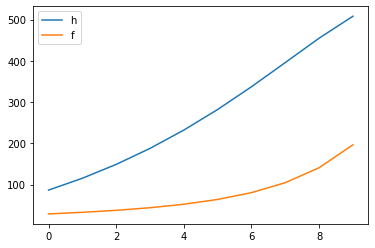

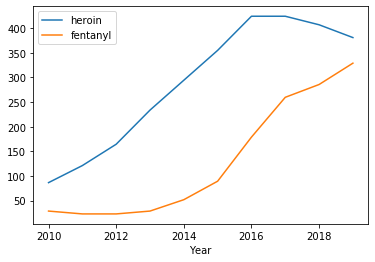

In [40]:
'''
4. Compute the best model using the best net conversion value.
   Plot the simulated values and the real values.
'''

best_model(best_net_conversion, post_split_data, y0_post, t_post, av)

#### Pre split data: flat part

In [41]:
'''
1. Create time and starting variables
'''

t_pre, y0_pre = compute_starting_variables(pre_split_data)

In [42]:
'''
2. List of possibile values to try for the conversion rate.
   Compute RSS for each value and pick the best one.
'''

net_conversion_values = list(np.arange(0, 20, 0.5))

In [43]:
av = 1

In [44]:
'''
3. Run model and find best net conversion value
'''

best_net_conversion_pre = model_tuning(pre_split_data, y0_pre, t_pre, net_conversion_values, av)

Fitting the model 40 times
The best value to minimize heroin RSS is at index 4: 1537.6248809255253
The best value to minimize fentanyl RSS is at index 28: 56.84312724031002
The best value to minimize both RSS (i.e. global solution) is at index 16: 1993.658363119085
The best net conversion rate is 8.0


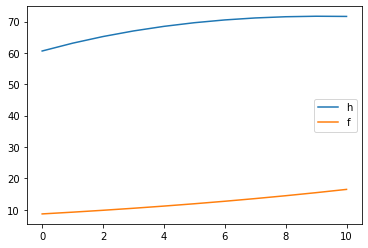

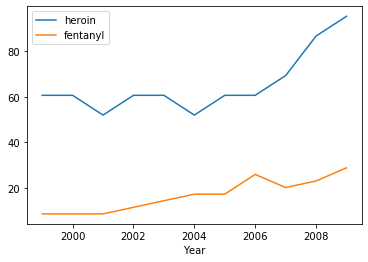

In [45]:
'''
4. Compute the best model using the best net conversion value.
   Plot the simulated values and the real values.
'''

best_model(best_net_conversion, pre_split_data, y0_pre, t_pre, av)

In [46]:
y0_pre
best_net_conversion
av

1

____________________________________________

# California

In [258]:
death_legal = pd.read_csv("CA_Death_Prescription Opioid-Related Overdose_TimeTrend_2021-05-26.csv", skiprows=[0, 1])[:58]

In [259]:
death_legal.head()

,Quarter,Annualized Quarterly Rate,Lower 95% CL,Upper 95% CL,Quarterly Count,12-Month Moving Avg.,Lower 95% CL.1,Upper 95% CL.1,12-Month Count
0,2006 Q1,2.85,2.68,3.03,261.0,0.00,0.00,0.00,0.0
1,2006 Q2,3.00,2.83,3.18,277.0,0.00,0.00,0.00,0.0
2,2006 Q3,2.99,2.82,3.18,275.0,0.00,0.00,0.00,0.0
3,2006 Q4,3.32,3.14,3.51,303.0,3.04,2.87,3.22,1116.0
4,2007 Q1,3.57,3.38,3.78,329.0,3.22,3.04,3.41,1184.0


In [260]:
death_heroin = pd.read_csv("CA_Death_Heroin-Related Overdose_TimeTrend_2021-05-26.csv", skiprows=[0, 1])[:58]

In [261]:
death_heroin.head()

,Quarter,Annualized Quarterly Rate,Lower 95% CL,Upper 95% CL,Quarterly Count,12-Month Moving Avg.,Lower 95% CL.1,Upper 95% CL.1,12-Month Count
0,2006 Q1,0.71,0.62,0.80,64.0,0.00,0.00,0.00,0.0
1,2006 Q2,0.85,0.76,0.95,77.0,0.00,0.00,0.00,0.0
2,2006 Q3,0.70,0.61,0.79,64.0,0.00,0.00,0.00,0.0
3,2006 Q4,0.69,0.61,0.78,63.0,0.74,0.65,0.83,268.0
4,2007 Q1,0.69,0.61,0.78,64.0,0.73,0.65,0.82,268.0


In [262]:
death_fentanyl = pd.read_csv("CA_Death_Fentanyl-Related Overdose _TimeTrend_2021-05-26.csv",skiprows=[0, 1])[:58]

In [263]:
death_fentanyl.head()

,Quarter,Annualized Quarterly Rate,Lower 95% CL,Upper 95% CL,Quarterly Count,12-Month Moving Avg.,Lower 95% CL.1,Upper 95% CL.1,12-Month Count
0,2006 Q1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2006 Q2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2006 Q3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2006 Q4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2007 Q1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


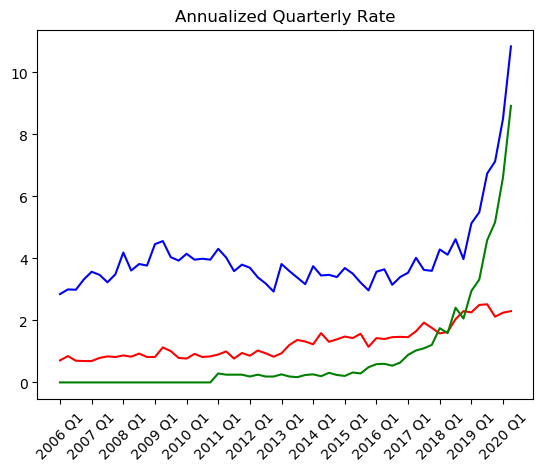

In [264]:
plt.plot(death_legal['Quarter'], death_legal['Annualized Quarterly Rate'], color='blue')
plt.plot(death_heroin['Quarter'], death_heroin['Annualized Quarterly Rate'], color='red')
plt.plot(death_fentanyl['Quarter'], death_fentanyl['Annualized Quarterly Rate'], color='green')

plt.title('Annualized Quarterly Rate')
plt.xticks(death_fentanyl['Quarter'][::4], rotation=45)
plt.show()

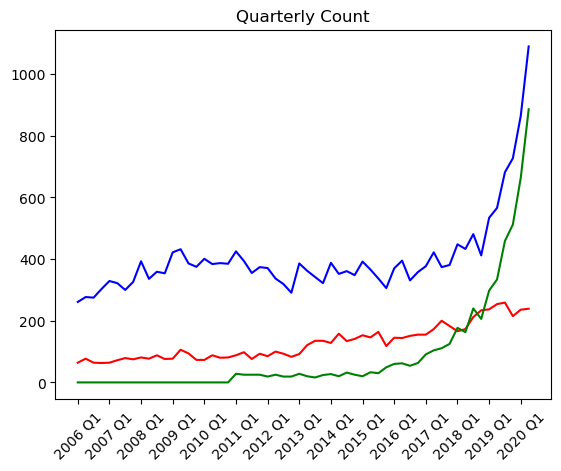

In [265]:
plt.plot(death_legal['Quarter'], death_legal['Quarterly Count'], color='blue')
plt.plot(death_heroin['Quarter'], death_heroin['Quarterly Count'], color='red')
plt.plot(death_fentanyl['Quarter'], death_fentanyl['Quarterly Count'], color='green')

plt.title('Quarterly Count')
plt.xticks(death_fentanyl['Quarter'][::4], rotation=45)
plt.show()

In [266]:
death_legal.set_index('Quarter', inplace=True)
death_heroin.set_index('Quarter', inplace=True)
death_fentanyl.set_index('Quarter', inplace=True)

In [267]:
col = 'Annualized Quarterly Rate'

deaths_california = death_legal[[col]].merge(death_heroin[[col]], left_index=True, right_index=True).merge(death_fentanyl[[col]], left_index=True, right_index=True)
deaths_california.columns = ['prescription_opioids', 'heroin', 'fentanyl']
deaths_california.head()

,prescription_opioids,heroin,fentanyl
Quarter,,,
2006 Q1,2.85,0.71,0.0
2006 Q2,3.00,0.85,0.0
2006 Q3,2.99,0.70,0.0
2006 Q4,3.32,0.69,0.0
2007 Q1,3.57,0.69,0.0


In [268]:
# Compute number of users from deaths and death rate

current_users_california = deaths_california.copy()

current_users_california['prescription_opioids'] = current_users_california['prescription_opioids'].apply(lambda x: inverse_death_rate(x, death_rate_prescription_opioids))
current_users_california['heroin'] = current_users_california['heroin'].apply(lambda x: inverse_death_rate(x, death_rate_heroin))
current_users_california['fentanyl'] = current_users_california['fentanyl'].apply(lambda x: inverse_death_rate(x, death_rate_fentanyl))

In [269]:
current_users_california = current_users_california[['heroin', 'fentanyl']]
current_users_california.head()

,heroin,fentanyl
Quarter,,
2006 Q1,47.333333,0.0
2006 Q2,56.666667,0.0
2006 Q3,46.666667,0.0
2006 Q4,46.000000,0.0
2007 Q1,46.000000,0.0


In [270]:
# All numbers in the data is relative to a population of 10'000 individuals
# Divide by N to obtain the fraction

N = 10000

current_users_california_fractions = current_users_california.copy()
current_users_california_fractions /= N

In [271]:
current_users_california_fractions.head()

,heroin,fentanyl
Quarter,,
2006 Q1,0.004733,0.0
2006 Q2,0.005667,0.0
2006 Q3,0.004667,0.0
2006 Q4,0.004600,0.0
2007 Q1,0.004600,0.0


In [272]:
data = current_users_california

In [273]:
current_users_california

,heroin,fentanyl
Quarter,,
2006 Q1,47.333333,0.000000
2006 Q2,56.666667,0.000000
2006 Q3,46.666667,0.000000
2006 Q4,46.000000,0.000000
2007 Q1,46.000000,0.000000
2007 Q2,52.666667,0.000000
2007 Q3,56.000000,0.000000
2007 Q4,54.666667,0.000000
2008 Q1,58.000000,0.000000


In [274]:
'''
1. Create time and starting variables
'''

t, y0 = compute_starting_variables(data)

In [275]:
y0

(9952.666666666666, 47.333333333333336, 0.0, 0)

In [276]:
# Fentanyl needs to contain at least 1 obs

y0 = (y0[0], y0[1], 5.0, y0[3])

In [277]:
y0

(9952.666666666666, 47.333333333333336, 5.0, 0)

In [182]:
'''
2. List of possibile values to try for the conversion rate.
   Compute RSS for each value and pick the best one.
'''

net_conversion_values = list(np.arange(0, 20, 0.5))

In [183]:
av = 30

In [191]:
net_conversion_values

[0.0,
 0.5,
 1.0,
 1.5,
 2.0,
 2.5,
 3.0,
 3.5,
 4.0,
 4.5,
 5.0,
 5.5,
 6.0,
 6.5,
 7.0,
 7.5,
 8.0,
 8.5,
 9.0,
 9.5,
 10.0,
 10.5,
 11.0,
 11.5,
 12.0,
 12.5,
 13.0,
 13.5,
 14.0,
 14.5,
 15.0,
 15.5,
 16.0,
 16.5,
 17.0,
 17.5,
 18.0,
 18.5,
 19.0,
 19.5]

In [192]:
av

30

In [184]:
'''
3. Run model and find best net conversion value
'''

best_net_conversion = model_tuning(data, y0, t, net_conversion_values, av)

C:\Users\Sandro\anaconda3.3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Fitting the model 40 times
The best value to minimize heroin RSS is at index 36: 325609.289308182
The best value to minimize fentanyl RSS is at index 2: 36572.742312116156
The best value to minimize both RSS (i.e. global solution) is at index 23: 1117577.7366019776
The best net conversion rate is 11.5


In [185]:
best_model(best_net_conversion, data, y0, t, av, df=True)

,s,h,f,r
0,9938.528139,6.147186e+01,5.000000,0.000000
1,9920.188126,7.130858e+01,5.630736,5.720995
2,9900.825930,8.091627e+01,6.394873,9.385858
3,9880.458269,9.025127e+01,7.327453,12.021722
4,9859.103819,9.926196e+01,8.472407,14.138010
5,9836.783279,1.078851e+02,9.885349,15.987095
6,9813.519622,1.160416e+02,11.636949,17.693669
7,9789.338536,1.236320e+02,13.816980,19.318935
8,9764.269046,1.305311e+02,16.539025,20.892433
9,9738.344326,1.365818e+02,19.945656,22.427792


C:\Users\Sandro\anaconda3.3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


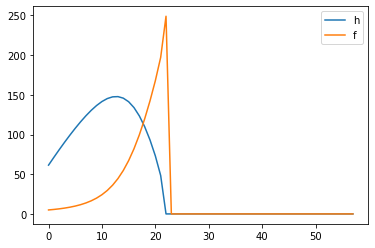

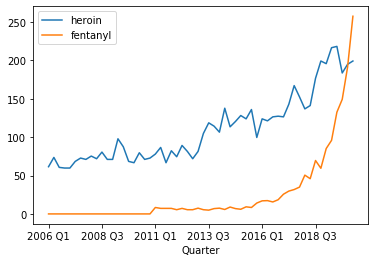

In [186]:
'''
4. Compute the best model using the best net conversion value.
   Plot the simulated values and the real values.
'''

best_model(best_net_conversion, data, y0, t, av)

C:\Users\Sandro\anaconda3.3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Fitting the model 40 times
The best value to minimize heroin RSS is at index 34: 222402.72721400877
The best value to minimize fentanyl RSS is at index 2: 36572.742312116156
The best value to minimize both RSS (i.e. global solution) is at index 25: 1103838.819189677
The best net conversion rate is 12.5


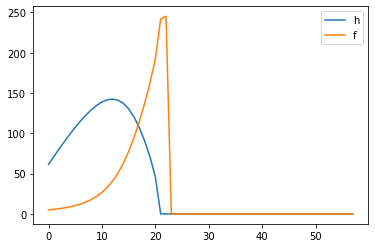

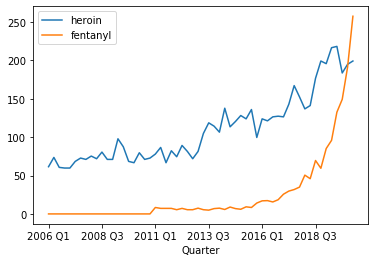

In [187]:
data = current_users_california

'''
1. Create time and starting variables
'''

t, y0 = compute_starting_variables(data)

y0

# Fentanyl needs to contain at least 1 obs

y0 = (y0[0], y0[1], 5.0, y0[3])

y0

'''
2. List of possibile values to try for the conversion rate.
   Compute RSS for each value and pick the best one.
'''

net_conversion_values = list(np.arange(0, 20, 0.5))

av = 30

'''
3. Run model and find best net conversion value
'''

best_net_conversion = model_tuning(data, y0, t, net_conversion_values, av)

best_model(best_net_conversion, data, y0, t, av, df=True)

'''
4. Compute the best model using the best net conversion value.
   Plot the simulated values and the real values.
'''

best_model(best_net_conversion, data, y0, t, av)

In [257]:
y0

(9930.735930735931, 60.6060606060606, 8.658008658008658, 0)

## S

In [278]:
def sensitivity_analysis_cal(prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl,net_conversion, av):
    import uncertainpy as un
    import chaospy as cp # To create distributions
    import numpy as np # For the time array
    from scipy.integrate import odeint
    ndays = 21
    
    S, H, F, R = (9952.666666666666, 47.333333333333336, 5.0, 0)
    N = S+H+F+R
    t = range(1, ndays+1, 1) 
    
    def opioids_model(INPUT, t, prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl,net_conversion, av):

        S, H, F, R = INPUT[0], INPUT[1], INPUT[2], INPUT[3]


        S_d_t = -(prescription_addiction + illegal_addiction_rate*av*(H+F)/N)*S + death_rate_heroin*H + death_rate_fentanyl*F
        H_d_t = (prescription_addiction + illegal_addiction_rate*av*(H+F)/N)*S*(1-f_laced_rate) - f_laced_rate*H - net_conversion*H*F/N - recovery_rate*H + relapse_rate*H*R/N - death_rate_heroin*H
        F_d_t = (prescription_addiction + illegal_addiction_rate*av*(H+F)/N)*S*f_laced_rate + f_laced_rate*H + net_conversion*H*F/N - recovery_rate*F + relapse_rate*F*R/N - death_rate_fentanyl*F
        R_d_t = recovery_rate*(H+F) - relapse_rate*R

        return S_d_t, H_d_t, F_d_t, R_d_t
    cases = odeint(opioids_model, (S, H, F, R) , t, args=(prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl, net_conversion,av) )
    return t,cases[:,0]
    
    
    

In [279]:
model = un.Model(run = sensitivity_analysis_cal,labels=["Time","S"])

In [280]:
# Normale --> calcolato
# Uniforme --> assunto
prescription_addiction = cp.Normal(0.001116, 0.001) 
illegal_addiction_rate = cp.Normal(0.0036, 0.001) 
f_laced_rate =cp.Uniform(0.05,0.2)
recovery_rate =cp.Normal(0.11,0.01)
relapse_rate = cp.Normal(0.7,0.01) 
net_conversion = 5.5
av = cp.Normal(30,1)
death_rate_heroin = 0.015 #cp.Uniform(0.01,0.02)
death_rate_fentanyl = 0.015 #cp.Uniform(0.01,0.02)

In [281]:
parameters = {'prescription_addiction':prescription_addiction,
 'illegal_addiction_rate':illegal_addiction_rate,
 'f_laced_rate':f_laced_rate,
 'recovery_rate':recovery_rate,
 'relapse_rate':relapse_rate,
 'death_rate_heroin':death_rate_heroin,
 'death_rate_fentanyl':death_rate_fentanyl,
    'net_conversion':net_conversion,
             'av': av}

In [282]:
parameters = un.Parameters(parameters)

In [283]:
UQ_S_cal=un.UncertaintyQuantification(model=model,parameters=parameters)

On Windows machines everything in your script must be inside of an if __name__ == '__main__': block in order for multiprocess to work.


In [284]:
data_S_cal = UQ_S_cal.quantify()

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead
Calculating statistics from PCE: 100%|█████████████████████████████████████████████████| 1/1 [24:05<00:00, 1445.98s/it]


Saving data as: data\sensitivity_analysis_cal.h5


In [285]:
UQ_S_cal.plot(folder='S_cal')
"""In summary, first‐order sensitivity indices as the main effect are used to measure the fractional contribution of
a single parameter to the output variance. 
Second‐order sensitivity indices are used to measure the fractional contribution of parameter interactions 
to the output variance."""

#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5006244/#:~:text=In%20summary%2C%20first%E2%80%90order%20sensitivity,interactions%20to%20the%20output%20variance.

'In summary, first‐order sensitivity indices as the main effect are used to measure the fractional contribution of\na single parameter to the output variance. \nSecond‐order sensitivity indices are used to measure the fractional contribution of parameter interactions \nto the output variance.'

UQ.plotting.sensitivity_1d(feature="sensitivity_analysis")

UQ.plotting.average_sensitivity_all()

UQ.plotting.plot_all_sensitivities()

UQ.plotting.plot_condensed()

## H

In [286]:
def sensitivity_analysis_cal(prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl,net_conversion , av):
    import uncertainpy as un
    import chaospy as cp # To create distributions
    import numpy as np # For the time array
    from scipy.integrate import odeint
    ndays = 21
    
    S, H, F, R = (9952.666666666666, 47.333333333333336, 5.0, 0)
    N = S+H+F+R
    t = range(1, ndays+1, 1) 
    
    def opioids_model(INPUT, t, prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl,net_conversion, av):

        S, H, F, R = INPUT[0], INPUT[1], INPUT[2], INPUT[3]


        S_d_t = -(prescription_addiction + illegal_addiction_rate*av*(H+F)/N)*S + death_rate_heroin*H + death_rate_fentanyl*F
        H_d_t = (prescription_addiction + illegal_addiction_rate*av*(H+F)/N)*S*(1-f_laced_rate) - f_laced_rate*H - net_conversion*H*F/N - recovery_rate*H + relapse_rate*H*R/N - death_rate_heroin*H
        F_d_t = (prescription_addiction + illegal_addiction_rate*av*(H+F)/N)*S*f_laced_rate + f_laced_rate*H + net_conversion*H*F/N - recovery_rate*F + relapse_rate*F*R/N - death_rate_fentanyl*F
        R_d_t = recovery_rate*(H+F) - relapse_rate*R

        return S_d_t, H_d_t, F_d_t, R_d_t
    cases = odeint(opioids_model, (S, H, F, R) , t, args=(prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl, net_conversion,av) )
    return t,cases[:,1]
    
    

In [287]:
model = un.Model(run = sensitivity_analysis_cal,labels=["Time","H"])

In [288]:
# Normale --> calcolato
# Uniforme --> assunto
prescription_addiction = cp.Normal(0.001116, 0.001) 
illegal_addiction_rate = cp.Normal(0.0036, 0.001) 
f_laced_rate =cp.Uniform(0.05,0.2)
recovery_rate =cp.Normal(0.11,0.01)
relapse_rate = cp.Normal(0.7,0.01) 
net_conversion = 5.5
av = cp.Normal(30,1)
death_rate_heroin = 0.015 #cp.Uniform(0.01,0.02)
death_rate_fentanyl = 0.015 #cp.Uniform(0.01,0.02)

In [289]:
parameters = {'prescription_addiction':prescription_addiction,
 'illegal_addiction_rate':illegal_addiction_rate,
 'f_laced_rate':f_laced_rate,
 'recovery_rate':recovery_rate,
 'relapse_rate':relapse_rate,
 'death_rate_heroin':death_rate_heroin,
 'death_rate_fentanyl':death_rate_fentanyl,
    'net_conversion':net_conversion,
             'av': av}

In [290]:
parameters = un.Parameters(parameters)

In [291]:
UQ_H_cal = un.UncertaintyQuantification(model=model,parameters=parameters)

On Windows machines everything in your script must be inside of an if __name__ == '__main__': block in order for multiprocess to work.


In [292]:
data_H_cal = UQ_H_cal.quantify()

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead
Calculating statistics from PCE: 100%|█████████████████████████████████████████████████| 1/1 [24:04<00:00, 1444.60s/it]


Saving data as: data\sensitivity_analysis_cal.h5


In [293]:
UQ_H_cal.plot(folder='H_cal')
"""In summary, first‐order sensitivity indices as the main effect are used to measure the fractional contribution of
a single parameter to the output variance. 
Second‐order sensitivity indices are used to measure the fractional contribution of parameter interactions 
to the output variance."""

#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5006244/#:~:text=In%20summary%2C%20first%E2%80%90order%20sensitivity,interactions%20to%20the%20output%20variance.

'In summary, first‐order sensitivity indices as the main effect are used to measure the fractional contribution of\na single parameter to the output variance. \nSecond‐order sensitivity indices are used to measure the fractional contribution of parameter interactions \nto the output variance.'

UQ.plotting.sensitivity_1d(feature="sensitivity_analysis")

UQ.plotting.average_sensitivity_all()

UQ.plotting.plot_all_sensitivities()

UQ.plotting.plot_condensed()

## F

In [294]:
def sensitivity_analysis_cal(prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl,net_conversion , av):
    import uncertainpy as un
    import chaospy as cp # To create distributions
    import numpy as np # For the time array
    from scipy.integrate import odeint
    ndays = 21
    
    S, H, F, R = (9952.666666666666, 47.333333333333336, 5.0, 0)
    N = S+H+F+R
    t = range(1, ndays+1, 1) 
    
    def opioids_model(INPUT, t, prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl,net_conversion, av):

        S, H, F, R = INPUT[0], INPUT[1], INPUT[2], INPUT[3]


        S_d_t = -(prescription_addiction + illegal_addiction_rate*av*(H+F)/N)*S + death_rate_heroin*H + death_rate_fentanyl*F
        H_d_t = (prescription_addiction + illegal_addiction_rate*av*(H+F)/N)*S*(1-f_laced_rate) - f_laced_rate*H - net_conversion*H*F/N - recovery_rate*H + relapse_rate*H*R/N - death_rate_heroin*H
        F_d_t = (prescription_addiction + illegal_addiction_rate*av*(H+F)/N)*S*f_laced_rate + f_laced_rate*H + net_conversion*H*F/N - recovery_rate*F + relapse_rate*F*R/N - death_rate_fentanyl*F
        R_d_t = recovery_rate*(H+F) - relapse_rate*R

        return S_d_t, H_d_t, F_d_t, R_d_t
    cases = odeint(opioids_model, (S, H, F, R) , t, args=(prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl, net_conversion,av) )
    return t,cases[:,2]
    
    
    

In [295]:
model = un.Model(run = sensitivity_analysis_cal,labels=["Time","F"])

In [296]:
# Normale --> calcolato
# Uniforme --> assunto
prescription_addiction = cp.Normal(0.001116, 0.001) 
illegal_addiction_rate = cp.Normal(0.0036, 0.001) 
f_laced_rate =cp.Uniform(0.05,0.2)
recovery_rate =cp.Normal(0.11,0.01)
relapse_rate = cp.Normal(0.7,0.01) 
net_conversion = 5.5
av = cp.Normal(30,1)
death_rate_heroin = 0.015 #cp.Uniform(0.01,0.02)
death_rate_fentanyl = 0.015 #cp.Uniform(0.01,0.02)

In [297]:
parameters = {'prescription_addiction':prescription_addiction,
 'illegal_addiction_rate':illegal_addiction_rate,
 'f_laced_rate':f_laced_rate,
 'recovery_rate':recovery_rate,
 'relapse_rate':relapse_rate,
 'death_rate_heroin':death_rate_heroin,
 'death_rate_fentanyl':death_rate_fentanyl,
    'net_conversion':net_conversion,
             'av': av}

In [298]:
parameters = un.Parameters(parameters)

In [299]:
UQ_F_cal=un.UncertaintyQuantification(model=model,parameters=parameters)

On Windows machines everything in your script must be inside of an if __name__ == '__main__': block in order for multiprocess to work.


In [300]:
data_F_cal = UQ_F_cal.quantify()

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead
Calculating statistics from PCE: 100%|█████████████████████████████████████████████████| 1/1 [24:32<00:00, 1472.66s/it]


Saving data as: data\sensitivity_analysis_cal.h5


In [301]:
UQ_F_cal.plot(folder='F_cal')
"""In summary, first‐order sensitivity indices as the main effect are used to measure the fractional contribution of
a single parameter to the output variance. 
Second‐order sensitivity indices are used to measure the fractional contribution of parameter interactions 
to the output variance."""

#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5006244/#:~:text=In%20summary%2C%20first%E2%80%90order%20sensitivity,interactions%20to%20the%20output%20variance.

'In summary, first‐order sensitivity indices as the main effect are used to measure the fractional contribution of\na single parameter to the output variance. \nSecond‐order sensitivity indices are used to measure the fractional contribution of parameter interactions \nto the output variance.'

UQ.plotting.sensitivity_1d(feature="sensitivity_analysis")

UQ.plotting.average_sensitivity_all()

UQ.plotting.plot_all_sensitivities()

UQ.plotting.plot_condensed()

## R

In [302]:
def sensitivity_analysis_cal(prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl,net_conversion, av):
    import uncertainpy as un
    import chaospy as cp # To create distributions
    import numpy as np # For the time array
    from scipy.integrate import odeint
    ndays = 21
    
    S, H, F, R = (9952.666666666666, 47.333333333333336, 5.0, 0)
    N = S+H+F+R
    t = range(1, ndays+1, 1) 
    
    def opioids_model(INPUT, t, prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl,net_conversion, av):

        S, H, F, R = INPUT[0], INPUT[1], INPUT[2], INPUT[3]


        S_d_t = -(prescription_addiction + illegal_addiction_rate*av*(H+F)/N)*S + death_rate_heroin*H + death_rate_fentanyl*F
        H_d_t = (prescription_addiction + illegal_addiction_rate*av*(H+F)/N)*S*(1-f_laced_rate) - f_laced_rate*H - net_conversion*H*F/N - recovery_rate*H + relapse_rate*H*R/N - death_rate_heroin*H
        F_d_t = (prescription_addiction + illegal_addiction_rate*av*(H+F)/N)*S*f_laced_rate + f_laced_rate*H + net_conversion*H*F/N - recovery_rate*F + relapse_rate*F*R/N - death_rate_fentanyl*F
        R_d_t = recovery_rate*(H+F) - relapse_rate*R

        return S_d_t, H_d_t, F_d_t, R_d_t
    cases = odeint(opioids_model, (S, H, F, R) , t, args=(prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl, net_conversion,av) )
    return t,cases[:,3]
    
    

In [303]:
model = un.Model(run = sensitivity_analysis_cal,labels=["Time","R"])

In [304]:
# Normale --> calcolato
# Uniforme --> assunto
prescription_addiction = cp.Normal(0.001116, 0.001) 
illegal_addiction_rate = cp.Normal(0.0036, 0.001) 
f_laced_rate =cp.Uniform(0.05,0.2)
recovery_rate =cp.Normal(0.11,0.01)
relapse_rate = cp.Normal(0.7,0.01) 
net_conversion = 5.5
av = cp.Normal(30,1)
death_rate_heroin = 0.015 #cp.Uniform(0.01,0.02)
death_rate_fentanyl = 0.015 #cp.Uniform(0.01,0.02)

In [305]:
parameters = {'prescription_addiction':prescription_addiction,
 'illegal_addiction_rate':illegal_addiction_rate,
 'f_laced_rate':f_laced_rate,
 'recovery_rate':recovery_rate,
 'relapse_rate':relapse_rate,
 'death_rate_heroin':death_rate_heroin,
 'death_rate_fentanyl':death_rate_fentanyl,
    'net_conversion':net_conversion,
             'av': av}

In [306]:
parameters = un.Parameters(parameters)

In [307]:
UQ_R_cal=un.UncertaintyQuantification(model=model,parameters=parameters)

On Windows machines everything in your script must be inside of an if __name__ == '__main__': block in order for multiprocess to work.


In [308]:
data_R_cal = UQ_R_cal.quantify()

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead
Calculating statistics from PCE: 100%|█████████████████████████████████████████████████| 1/1 [20:55<00:00, 1255.70s/it]


Saving data as: data\sensitivity_analysis_cal.h5


In [309]:
UQ_R_cal.plot(folder='R')
"""In summary, first‐order sensitivity indices as the main effect are used to measure the fractional contribution of
a single parameter to the output variance. 
Second‐order sensitivity indices are used to measure the fractional contribution of parameter interactions 
to the output variance."""

#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5006244/#:~:text=In%20summary%2C%20first%E2%80%90order%20sensitivity,interactions%20to%20the%20output%20variance.

'In summary, first‐order sensitivity indices as the main effect are used to measure the fractional contribution of\na single parameter to the output variance. \nSecond‐order sensitivity indices are used to measure the fractional contribution of parameter interactions \nto the output variance.'

UQ.plotting.sensitivity_1d(feature="sensitivity_analysis")

UQ.plotting.average_sensitivity_all()

UQ.plotting.plot_all_sensitivities()

UQ.plotting.plot_condensed()

In [68]:
def opioids_model(INPUT, t, prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl, net_conversion,availability, death_rate_natural):
    
    S, H, F, R = INPUT[0], INPUT[1], INPUT[2], INPUT[3]
    
    S_d_t = -(prescription_addiction + illegal_addiction_rate*availability*(H+F)/N)*S + death_rate_heroin*H + death_rate_fentanyl*F
    H_d_t = (prescription_addiction + illegal_addiction_rate*availability*(H+F)/N)*S*(1-f_laced_rate) - f_laced_rate*H - net_conversion*H*F/N - recovery_rate*H + relapse_rate*H*R/N - death_rate_heroin*H
    F_d_t = (prescription_addiction + illegal_addiction_rate*availability*(H+F)/N)*S*f_laced_rate + f_laced_rate*H + net_conversion*H*F/N - recovery_rate*F + relapse_rate*F*R/N - death_rate_fentanyl*F
    R_d_t = recovery_rate*(H+F) - relapse_rate*R
    
    return S_d_t, H_d_t, F_d_t, R_d_t

In [64]:
cp.Normal(0.1,0.005)

array(0.)

In [97]:
def variability(parametro):
    
    ndays = 21
    S, H, F, R = (99960.64333519242, 36.356664807585055, 2.9999999999999996, 0)
    N = S+H+F+R
    t = range(1, ndays+1, 1)
    
    # Normale --> calcolato
    # Uniforme --> assunto
    prescription_addiction = 0.0036
    illegal_addiction_rate = 0.5 
    f_laced_rate = 0.5
    recovery_rate = 0.11 #[0.09,0.11] 0.04
    relapse_rate = 0.7 #[0.6,0.8] 0.05
    net_conversion = best_net_conversion
    availability = global_availability_ratio
    death_rate_heroin = 0.015 
    #death_rate_fentanyl = parametro #[0.09,0.11]
    death_rate_natural = death_rate_prescription_opioids
    
    
    laced_exponent = -24.52*(F/H - 0.3)
    f_laced_rate = f_laced_rate/ (1 + np.exp(laced_exponent))
    
    
    
    #_______________
    death_rate_heroin = death_rate_heroin - death_rate_natural
    #death_rate_fentanyl = death_rate_fentanyl - death_rate_natural
    
    i = 0
    for death_rate_fentanyl in parametro:
        cases = odeint(opioids_model, (S, H, F, R) , t, args=(prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
               relapse_rate,death_rate_heroin,death_rate_fentanyl, net_conversion,availability, death_rate_natural) )
        death_rate_fentanyl = death_rate_fentanyl - death_rate_natural
        if i ==0:
            a = pd.DataFrame(cases[:,3])
            i=i+1
        else:
            a = pd.concat([a,pd.DataFrame(cases[:,3])],axis=1)
    #a["mean"] = a.mean(axis=0)
    return t,a

In [126]:
paramatro = np.linspace(0,1,1000)

In [127]:
t,df = variability(paramatro)

In [128]:
df

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5596.326388,5596.090115,5595.853846,5595.617583,5595.381324,5595.145070,5594.908820,5594.672575,5594.436335,5594.200100,...,5364.753431,5364.521933,5364.290441,5364.058963,5363.827481,5363.595985,5363.364512,5363.133054,5362.901591,5362.670130
2,10004.895981,10004.435862,10003.975796,10003.515745,10003.055547,10002.595604,10002.135413,10001.675480,10001.215096,10000.755469,...,9553.257824,9552.805799,9552.353499,9551.901478,9551.449158,9550.997158,9550.544878,9550.092951,9549.640276,9549.188774
3,11908.963876,11908.383716,11907.803518,11907.223451,11906.643308,11906.063260,11905.483143,11904.903119,11904.323256,11903.743045,...,11340.497492,11339.929612,11339.361286,11338.793158,11338.225022,11337.656981,11337.088920,11336.520937,11335.952954,11335.384849
4,12670.931374,12670.273360,12669.615315,12668.957533,12668.299477,12667.641621,12666.983671,12666.325561,12665.668643,12665.010100,...,12028.032040,12027.391524,12026.750782,12026.110344,12025.469808,12024.829328,12024.188493,12023.547967,12022.907407,12022.267229
5,12906.088957,12905.369596,12904.650171,12903.931209,12903.211578,12902.492616,12901.773024,12901.053955,12900.335312,12899.615651,...,12205.718971,12205.023411,12204.327993,12203.633000,12202.937537,12202.242451,12201.546889,12200.851656,12200.156717,12199.461456
6,12893.442652,12892.667745,12891.892772,12891.117875,12890.342953,12889.568145,12888.793302,12888.018533,12887.244114,12886.469088,...,12142.061416,12141.318454,12140.575476,12139.832888,12139.089913,12138.347169,12137.604408,12136.861667,12136.119172,12135.376347
7,12759.732728,12758.904084,12758.074930,12757.245890,12756.417151,12755.588242,12754.759478,12753.930741,12753.102085,12752.273722,...,11959.637839,11958.850536,11958.063096,11957.275837,11956.488639,11955.701237,11954.914001,11954.126824,11953.339666,11952.552616
8,12562.568039,12561.685576,12560.802340,12559.919408,12559.036841,12558.153974,12557.271340,12556.388728,12555.506242,12554.623906,...,11714.594798,11713.764832,11712.934234,11712.103967,11711.273819,11710.443738,11709.613352,11708.783271,11707.953262,11707.123387
9,12328.148222,12327.211753,12326.274249,12325.336984,12324.400220,12323.463227,12322.526627,12321.589723,12320.653262,12319.716491,...,11432.826538,11431.954727,11431.082520,11430.210550,11429.338550,11428.467204,11427.595103,11426.723372,11425.851849,11424.980218


In [131]:
def plotting_param (df,t):
    n,p = df.shape
    for col in range(p):
        plt.plot(t,df.iloc[:,col],alpha=0.002, color="red")
        #plt.ylim((12000))

In [4]:
def opioids_model(INPUT, t, prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
           relapse_rate,death_rate_heroin,death_rate_fentanyl,net_conversion, availability):
    
    S, H, F, R = INPUT[0], INPUT[1], INPUT[2], INPUT[3]
    N = S + H + F + R

    laced_exponent = -24.52*(F/H - 0.3)
    f_laced_rate = f_laced_rate / (1 + np.exp(laced_exponent))

    #if params['lower_bound_f_laced_rate']:
    #    if not f_laced_rate > 0.01:
    #        f_laced_rate = 0.01
#
    

    death_rate_heroin = death_rate_heroin - death_rate_natural
    death_rate_fentanyl = death_rate_fentanyl - death_rate_natural
    
    S_d_t = -(prescription_addiction + illegal_addiction_rate*availability*(H+F)/N)*S + death_rate_heroin*H + death_rate_fentanyl*F
    H_d_t = (prescription_addiction + illegal_addiction_rate*availability*(H+F)/N)*S*(1-f_laced_rate) - f_laced_rate*H - net_conversion*H*F/N - recovery_rate*H + relapse_rate*H*R/N - death_rate_heroin*H
    F_d_t = (prescription_addiction + illegal_addiction_rate*availability*(H+F)/N)*S*f_laced_rate + f_laced_rate*H + net_conversion*H*F/N - recovery_rate*F + relapse_rate*F*R/N - death_rate_fentanyl*F
    R_d_t = recovery_rate*(H+F) - relapse_rate*R
    
    
    return S_d_t, H_d_t, F_d_t, R_d_t

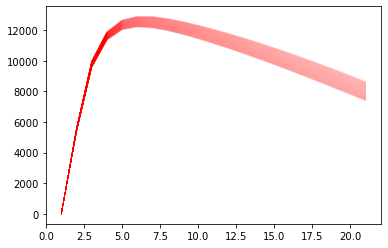

In [132]:
plotting_param(df,t)

In [5]:
#def opioids_model(INPUT, t, prescription_addiction,illegal_addiction_rate,f_laced_rate,recovery_rate,
#           relapse_rate,death_rate_heroin,death_rate_fentanyl,net_conversion, av):
#
#        S, H, F, R = INPUT[0], INPUT[1], INPUT[2], INPUT[3]
#
#
#        S_d_t = -(prescription_addiction + illegal_addiction_rate*av*(H+F)/N)*S + death_rate_heroin*H + death_rate_fentanyl*F
#        H_d_t = (prescription_addiction + illegal_addiction_rate*av*(H+F)/N)*S*(1-f_laced_rate) - f_laced_rate*H - net_conversion*H*F/N - recovery_rate*H + relapse_rate*H*R/N - death_rate_heroin*H
#        F_d_t = (prescription_addiction + illegal_addiction_rate*av*(H+F)/N)*S*f_laced_rate + f_laced_rate*H + net_conversion*H*F/N - recovery_rate*F + relapse_rate*F*R/N - death_rate_fentanyl*F
#        R_d_t = recovery_rate*(H+F) - relapse_rate*R
#
#        return S_d_t, H_d_t, F_d_t, R_d_t

_________________________

In [166]:
def opioids_model(INPUT, t, params,other):
    
    S, H, F, R = INPUT[0], INPUT[1], INPUT[2], INPUT[3]
    N = S + H + F + R
    
    prescription_addiction = params['prescription_addiction']
    illegal_addiction_rate = params['illegal_addiction_rate']

    laced_exponent = -24.52*(F/H - 0.3)
    f_laced_rate = params['f_laced_rate'] / (1 + np.exp(laced_exponent))

    #if params['lower_bound_f_laced_rate']:
    #    if not f_laced_rate > 0.01:
    #        f_laced_rate = 0.01
    net_conversion = params["net_conversion"]

    availability = params['availability']

    recovery_rate = params['recovery_rate']
    relapse_rate = params['relapse_rate']

    death_rate_heroin = params['death_rate_heroin'] - params['death_rate_natural']
    death_rate_fentanyl = params['death_rate_fentanyl'] - params['death_rate_natural']
    
    S_d_t = -(prescription_addiction + illegal_addiction_rate*availability*(H+F)/N)*S + death_rate_heroin*H + death_rate_fentanyl*F
    H_d_t = (prescription_addiction + illegal_addiction_rate*availability*(H+F)/N)*S*(1-f_laced_rate) - f_laced_rate*H - net_conversion*H*F/N - recovery_rate*H + relapse_rate*H*R/N - death_rate_heroin*H
    F_d_t = (prescription_addiction + illegal_addiction_rate*availability*(H+F)/N)*S*f_laced_rate + f_laced_rate*H + net_conversion*H*F/N - recovery_rate*F + relapse_rate*F*R/N - death_rate_fentanyl*F
    R_d_t = recovery_rate*(H+F) - relapse_rate*R
    
    return S_d_t, H_d_t, F_d_t, R_d_t

In [364]:
def policy_analisis(parameter, changed_value,year_analysis):
    # Normale --> calcolato
    # Uniforme --> assunto
    diff = year_analysis - 2020
    
    other = 0
    S, H , F , R = y0
    N =  S+H+F+R
    
    prescription_addiction = 0.1*0.001116#moltiplicazione
    illegal_addiction_rate = 0.0036
    f_laced_rate = 0.5
    recovery_rate = 0.1 #[0.09,0.11] 0.04
    relapse_rate = 0.7 #[0.6,0.8] 0.05
    net_conversion = best_net_conversion
    availability = global_availability_ratio
    death_rate_heroin = 0.015 
    death_rate_fentanyl = 0.1 #[0.09,0.11]
    death_rate_natural = death_rate_prescription_opioids
    
    parameters = {'prescription_addiction':prescription_addiction,
     'illegal_addiction_rate':illegal_addiction_rate,
     'f_laced_rate':f_laced_rate,
     'recovery_rate':recovery_rate,
     'relapse_rate':relapse_rate,
     'death_rate_heroin':death_rate_heroin,
     'death_rate_fentanyl':death_rate_fentanyl,
        'net_conversion':net_conversion,
        'availability': availability,
        "death_rate_natural":death_rate_natural }
    
    if parameter == "prescription_addiction":
        old = prescription_addiction
        print(f"The old value: {old}\nThe new value is: {changed_value}")
        parameters_new = parameters.copy()
        parameters_new[parameter] = changed_value
        
    elif parameter == "recovery_rate":
        old = recovery_rate
        print(f"The old value: {old}\nThe new value is: {changed_value}")
        parameters_new = parameters.copy()
        parameters_new[parameter] = changed_value
        
    elif parameter == "relapse_rate":
        old = relapse_rate
        print(f"The old value: {old}\nThe new value is: {changed_value}")
        parameters_new = parameters.copy()
        parameters_new[parameter] = changed_value
        
    elif parameter == "death_rate_fentanyl":
        old = death_rate_fentanyl
        print(f"The old value: {old}\nThe new value is: {changed_value}")
        parameters_new = parameters.copy()
        parameters_new[parameter] = changed_value
        
    elif parameter == "illegal_addiction_rate":
        old = illegal_addiction_rate
        print(f"The old value: {old}\nThe new value is: {changed_value}")
        parameters_new = parameters.copy()
        parameters_new[parameter] = changed_value
        
    elif parameter == "f_laced_rate":
        old = f_laced_rate
        print(f"The old value: {old}\nThe new value is: {changed_value}")
        parameters_new = parameters.copy()
        parameters_new[parameter] = changed_value
        
    elif parameter == "net_conversion":
        old = net_conversion
        print(f"The old value: {old}\nThe new value is: {changed_value}")
        parameters_new = parameters.copy()
        parameters_new[parameter] = changed_value
        
    elif parameter == "availability":
        old = availability
        print(f"The old value: {old}\nThe new value is: {changed_value}")
        parameters_new = parameters.copy()
        parameters_new[parameter] = changed_value
        
    elif parameter == "death_rate_heroin":
        old = death_rate_heroin
        print(f"The old value: {old}\nThe new value is: {changed_value}")
        parameters_new = parameters.copy()
        parameters_new[parameter] = changed_value
        
    elif parameter == "death_rate_natural":
        old = death_rate_natural
        print(f"The old value: {old}\nThe new value is: {changed_value}")
        parameters_new = parameters.copy()
        parameters_new[parameter] = changed_value
        
    
    cases_old = odeint(opioids_model, y0 , np.arange(1999,2020), args=(parameters,other))
    
    S_L = cases_old[-1,0]
    H_L = cases_old[-1,1]
    F_L = cases_old[-1,2]
    R_L = cases_old[-1,3]
    
    
    
    cases_constant = odeint(opioids_model, (S_L,H_L,F_L,R_L)  , np.arange(2019,year_analysis), args=(parameters,other))
    cases_new = odeint(opioids_model, (S_L,H_L,F_L,R_L)  , np.arange(2019,year_analysis), args=(parameters_new,other))

    plot_policy(parameter,cases_old, cases_new, cases_constant , year_analysis)
    return cases_old , cases_new, cases_constant
   
    

In [365]:
np.arange(1999,1999+100)

array([1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031,
       2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042,
       2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053,
       2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064,
       2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075,
       2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086,
       2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097,
       2098])

In [366]:
plt.vlines()

TypeError: vlines() missing 3 required positional arguments: 'x', 'ymin', and 'ymax'

In [462]:
def plot_policy(param, case_old,case_new,cases_constant,t_fin):
    font = font_manager.FontProperties(family='Times New Roman')
    t = np.arange(1999,2020)
    t_new = np.arange(2019,t_fin)
    t_total = np.arange(1999,t_fin)
    
    S_d_t_old = case_old[:,0]
    H_d_t_old = case_old[:,1]
    F_d_t_old = case_old[:,2]
    R_d_t_old = case_old[:,3]
    
    S_d_t_new = case_new[:,0]
    H_d_t_new = case_new[:,1]
    F_d_t_new = case_new[:,2]
    R_d_t_new = case_new[:,3]
    
    S_d_t_cos = cases_constant[:,0]
    H_d_t_cos = cases_constant[:,1]
    F_d_t_cos = cases_constant[:,2]
    R_d_t_cos = cases_constant[:,3]
    
    max_value=np.array([H_d_t_old.max(),F_d_t_old.max(),R_d_t_old.max(),H_d_t_new.max(),F_d_t_new.max(),R_d_t_new.max(),H_d_t_cos.max(),F_d_t_cos.max(),R_d_t_cos.max()])
    i = max(max_value)
    
    
    plt.style.use("seaborn")
    csfont = {'fontname':'Times New Roman'}
    
    fig, ax = plt.subplots(1,2,figsize=(14,5))
    #ax[0].plot(t,S_d_t_old,label = "S")
    ax[0].plot(t,H_d_t_old,label = "H", color="blue")
    ax[0].plot(t,F_d_t_old,label = "F", color="green")
    ax[0].plot(t,R_d_t_old,label = "R", color="red")
    #ax[0].set_xticks(t, rotation=45,fontsize=10, **csfont)
    
    
    ax[0].set_title("Old differential equations", **csfont)
    #ax[0].legend(frameon=True, prop=font, loc='upper left')
    
    
     #ax[1].plot(t_new,S_d_t_cos,label = "S", linestyle="dashed")
    ax[0].plot(t_new,H_d_t_cos,label = "H_pred", linestyle="dashed",color="blue")
    ax[0].plot(t_new,F_d_t_cos,label = "F_pred", linestyle="dashed",color="green")
    ax[0].plot(t_new,R_d_t_cos,label = "R_pred", linestyle="dashed",color="red")
    ax[0].axvline(2019, label = "Interruption", color ="black", alpha=0.5)
    ax[0].set_xlabel("Year\n",**csfont)
    ax[0].set_ylim(-100,abs(i)+100)
    plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45, **csfont)
    plt.setp(ax[0].yaxis.get_majorticklabels(), **csfont)
    ax[0].set_ylabel("Number over 100,000 individuals",**csfont)
    #ax[0].set_yticks(np.arange(-200,abs(i)+100,200))
    ax[0].legend(frameon=True, prop=font,loc='upper left')
    
    
    
    #ax[0].plot(t,S_d_t_old)
    ax[1].plot(t,H_d_t_old, color="blue", label ="H")
    ax[1].plot(t,F_d_t_old, color="green",label ="F")
    ax[1].plot(t,R_d_t_old, color="red",label ="R")
    #ax[1].set_xticks(t, rotation=45,fontsize=10, **csfont)
    plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45, **csfont)
    plt.setp(ax[1].yaxis.get_majorticklabels(), **csfont)
    #ax[1].set_ylabel("Year",**csfont)
    
    
    #ax[1].plot(t_new,S_d_t_new,label = "S")
    ax[1].plot(t_new,H_d_t_new,label = "H pred", linestyle="dashed",color="blue")
    ax[1].plot(t_new,F_d_t_new,label = "F pred", linestyle="dashed",color="green")
    ax[1].plot(t_new,R_d_t_new,label = "R pred", linestyle="dashed",color="red")
    ax[1].axvline(2019, label = "Interruption", color ="black", alpha=0.5)
    #ax[1].set_xticks(t_total, **csfont)
    #ax[1].set_yticks(np.arange(-200,abs(i)+100,200))
    ax[1].set_ylabel("Number over 100,000 individuals",**csfont)
    ax[1].set_ylim(-100,abs(i)+100)
    ax[1].set_xlabel("Year\n",**csfont)
    ax[1].set_title(f"New differential equations changing {param}", **csfont)
    ax[1].legend(frameon=True, prop=font,loc='upper left')
    #print(i)

In [463]:
prescription_addiction = 0.1*0.001116#moltiplicazione
    illegal_addiction_rate = 0.0036
    f_laced_rate = 0.5
    recovery_rate = 0.1 #[0.09,0.11] 0.04
    relapse_rate = 0.7 #[0.6,0.8] 0.05
    net_conversion = best_net_conversion
    availability = global_availability_ratio
    death_rate_heroin = 0.015 
    death_rate_fentanyl = 0.1 #[0.09,0.11]
    death_rate_natural = death_rate_prescription_opioids

IndentationError: unexpected indent (<ipython-input-463-be0ed579f248>, line 2)

In [464]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

The old value: 0.0001116
The new value is: 5.58e-05


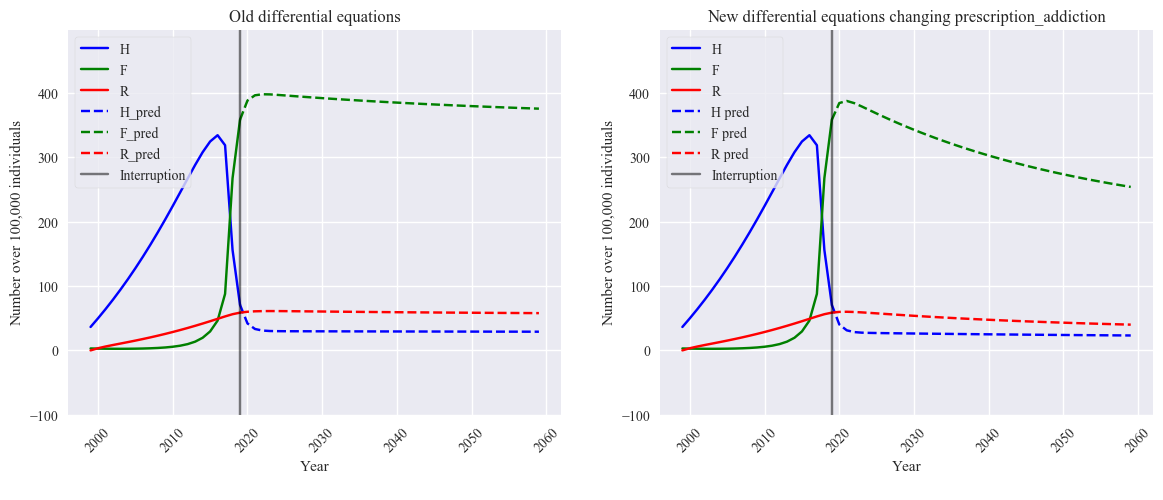

In [469]:
old ,new, cost = policy_analisis("prescription_addiction",0.1*0.001116*(1-0.5),2060)
plt.savefig("prescription_addiction - 50%")

The old value: 0.1
The new value is: 0.2


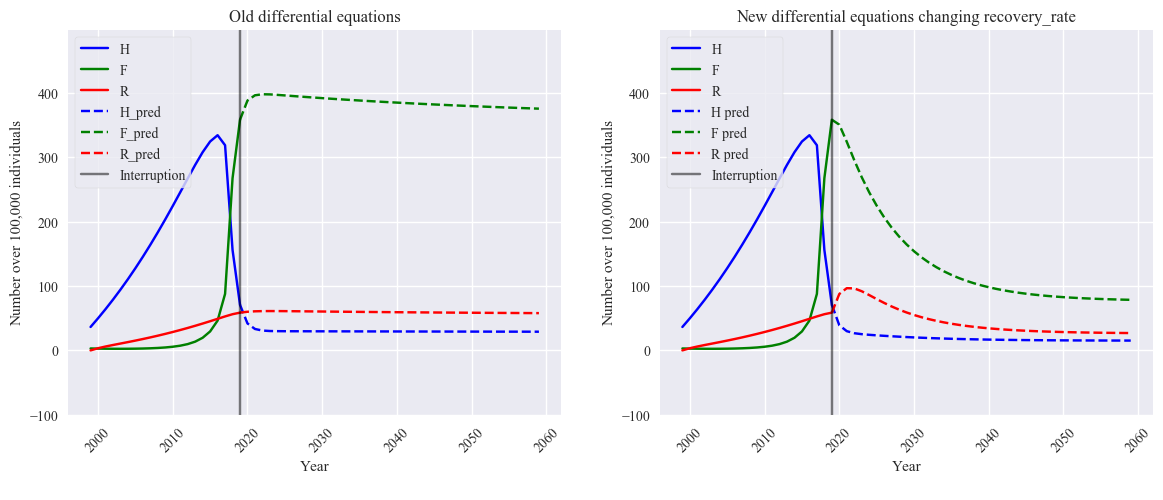

In [468]:
old ,new, cost = policy_analisis("recovery_rate",0.1*2,2060)
plt.savefig("recovery_rate + 100%")

In [ ]:
len(old[:,0])

In [123]:
y0

(99960.64333519242, 36.356664807585055, 2.9999999999999996, 0)

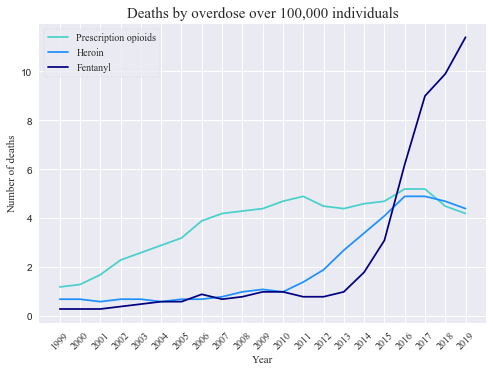

In [217]:
font = font_manager.FontProperties(family='Times New Roman')
#ax.legend(prop=font)
plt.style.use('seaborn')

#sns.color_palette("YlOrRd", as_cmap=True)
csfont = {'fontname':'Times New Roman'}
plt.plot(df_deaths.index, df_deaths['prescription_opioids'], color="mediumturquoise",label ="Prescription opioids")
plt.plot(df_deaths.index, df_deaths['heroin'], color="dodgerblue",label ="Heroin")
plt.plot(df_deaths.index, df_deaths['fentanyl'],color="navy"  ,label ="Fentanyl")

plt.title("Deaths by overdose over 100,000 individuals",fontsize=15, **csfont)
plt.ylabel("Number of deaths",fontsize=11, **csfont)
plt.xlabel("Year",**csfont)
plt.xticks(df_deaths.index, rotation=45,fontsize=10, **csfont)
plt.legend(frameon=True,prop=font )
plt.show();

In [124]:
opioids_model(y0,t,parameters)

(-35.684921280134645,
 31.958180214368415,
 -0.20892541499226525,
 3.935666480758506)

In [168]:
other =1

In [169]:
cases_old = odeint(func=opioids_model, y0=y0 , t=t, args=(parameters,other))

In [106]:
parameters

{'prescription_addiction': Uniform(lower=5.58e-05, upper=0.0002232),
 'illegal_addiction_rate': 0.0036,
 'f_laced_rate': 0.5,
 'recovery_rate': Normal(mu=0.1, sigma=0.04),
 'relapse_rate': Normal(mu=0.7, sigma=0.05),
 'death_rate_heroin': 0.015,
 'death_rate_fentanyl': Normal(mu=0.1, sigma=0.005),
 'net_conversion': 178.5,
 'availability': 44.166666666666664,
 'death_rate_natural': 0.007288}